In [1]:
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [2]:
# 1) Load & preprocess
df = pd.read_csv("Student_performance_data _.csv")

In [3]:
# 1a) Cap outliers
for col in ["StudyTimeWeekly", "Absences"]:
    low, high = np.percentile(df[col], [1, 99])
    df[col] = df[col].clip(low, high)

# 1b) Frequency‐encode categorical features
cat_cols = ["Gender", "Ethnicity", "ParentalEducation",
            "Tutoring", "ParentalSupport",
            "Extracurricular", "Sports", "Music", "Volunteering"]
for c in cat_cols:
    freq = df[c].value_counts(normalize=True)
    df[c + "_freq"] = df[c].map(freq)
df.drop(columns=cat_cols, inplace=True)

In [4]:
# 2) Train/test split
X = df.drop(columns=["StudentID", "GradeClass"])
y = df["GradeClass"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
# ====== FIXED CODE HERE =====
# 3) SMOTE on training data
sm = SMOTE(random_state=42)
X_sm_np, y_sm = sm.fit_resample(X_train, y_train)

# Convert immediately back to DataFrame to keep feature names
X_sm = pd.DataFrame(X_sm_np, columns=X_train.columns)

In [6]:
# 4) Feature selection via RF & median importance
rf_fs = RandomForestClassifier(n_estimators=100, random_state=42)
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")
selector.fit(X_sm, y_sm)

# transform and convert back to DataFrame with column names
X_sm_sel = selector.transform(X_sm)
X_sm_sel = pd.DataFrame(X_sm_sel, columns=X_sm.columns[selector.get_support()])

X_test_sel = selector.transform(X_test)
X_test_sel = pd.DataFrame(X_test_sel, columns=X_sm.columns[selector.get_support()])
# ===========================

selected = X_train.columns[selector.get_support()].tolist()
print("Selected features:", selected)

Selected features: ['StudyTimeWeekly', 'Absences', 'GPA', 'Ethnicity_freq', 'ParentalEducation_freq', 'Tutoring_freq', 'ParentalSupport_freq']


In [7]:
# 5) Split SMOTE’d data: model‐train vs threshold‐tuning
X_model, X_val, y_model, y_val = train_test_split(
    X_sm_sel, y_sm, test_size=0.2, random_state=42, stratify=y_sm
)

In [8]:
# 6) Build & train weighted soft‐voting ensemble
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=1000, random_state=42))
])
dt  = DecisionTreeClassifier(random_state=42)
rf  = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(
    n_estimators=200, max_depth=10, learning_rate=0.2,
    subsample=0.7, colsample_bytree=0.7,
    eval_metric="mlogloss",
    random_state=42
)

voting = VotingClassifier(
    estimators=[("lr", lr_pipe), ("dt", dt), ("rf", rf), ("xgb", xgb)],
    voting="soft",
    weights=[1, 1, 3, 2],
    n_jobs=-1
)

rf.fit(X_model, y_model)
dt.fit(X_model, y_model)
xgb.fit(X_model, y_model)
lr_pipe.fit(X_model, y_model)
voting.fit(X_model, y_model)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('lr',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=42))])),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_by...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 n_jobs=-1, voting='soft', weights=[1, 1, 3, 2])

In [9]:
# 7) Calibrate probabilities on hold‐out validation set using cv=5 (no prefit)
calib = CalibratedClassifierCV(voting, cv=5, method="isotonic")
calib.fit(X_val, y_val)

CalibratedClassifierCV(cv=5,
                       estimator=VotingClassifier(estimators=[('lr',
                                                               Pipeline(steps=[('scaler',
                                                                                StandardScaler()),
                                                                               ('lr',
                                                                                LogisticRegression(max_iter=1000,
                                                                                                   random_state=42))])),
                                                              ('dt',
                                                               DecisionTreeClassifier(random_state=42)),
                                                              ('rf',
                                                               RandomForestClassifier(n_estimators=200,
                                                                                      random_state=42)),
                                                              ('xgb',
                                                               XGBClassifier(base_score=None,
                                                                             booster=None,
                                                                             callbacks=No...
                                                                             interaction_constraints=None,
                                                                             learning_rate=0.2,
                                                                             max_bin=None,
                                                                             max_cat_threshold=None,
                                                                             max_cat_to_onehot=None,
                                                                             max_delta_step=None,
                                                                             max_depth=10,
                                                                             max_leaves=None,
                                                                             min_child_weight=None,
                                                                             missing=nan,
                                                                             monotone_constraints=None,
                                                                             multi_strategy=None,
                                                                             n_estimators=200,
                                                                             n_jobs=None,
                                                                             num_parallel_tree=None, ...))],
                                                  n_jobs=-1, voting='soft',
                                                  weights=[1, 1, 3, 2]),
                       method='isotonic')

In [10]:
# 8) Tune per‐class thresholds
probs_val = calib.predict_proba(X_val)
classes   = calib.classes_
best_thresh = {}
for idx, cls in enumerate(classes):
    y_true_bin = (y_val == cls).astype(int)
    best_f1, best_t = 0, 0.5
    for t in np.linspace(0.1, 0.9, 17):
        preds_bin = (probs_val[:, idx] >= t).astype(int)
        f1 = f1_score(y_true_bin, preds_bin)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    best_thresh[cls] = best_t
print("Optimal thresholds:", best_thresh)

Optimal thresholds: {np.float64(0.0): np.float64(0.4), np.float64(1.0): np.float64(0.30000000000000004), np.float64(2.0): np.float64(0.35), np.float64(3.0): np.float64(0.30000000000000004), np.float64(4.0): np.float64(0.25)}


In [11]:
# 9) Predict on test with threshold logic
probs_test = calib.predict_proba(X_test_sel)
y_pred = []
for p in probs_test:
    candidates = [classes[i] for i in range(len(classes)) if p[i] >= best_thresh[classes[i]]]
    if candidates:
        pick = max(candidates, key=lambda c: p[list(classes).index(c)])
    else:
        pick = classes[np.argmax(p)]
    y_pred.append(pick)

In [12]:
# 10) Final evaluation
print("Calibrated & thresholded Accuracy:", accuracy_score(y_test, y_pred))
print("\nFinal Classification Report:\n", classification_report(y_test, y_pred))

# ... plotting and correlation matrix code remains same, omitted here for brevity

# 10) Final evaluation
print("Calibrated & thresholded Accuracy:", accuracy_score(y_test, y_pred))
print("\nFinal Classification Report:\n", classification_report(y_test, y_pred))

Calibrated & thresholded Accuracy: 0.9102296450939458

Final Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.48      0.61        21
         1.0       0.87      0.85      0.86        54
         2.0       0.90      0.95      0.93        78
         3.0       0.87      0.87      0.87        83
         4.0       0.94      0.96      0.95       243

    accuracy                           0.91       479
   macro avg       0.88      0.82      0.84       479
weighted avg       0.91      0.91      0.91       479

Calibrated & thresholded Accuracy: 0.9102296450939458

Final Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.48      0.61        21
         1.0       0.87      0.85      0.86        54
         2.0       0.90      0.95      0.93        78
         3.0       0.87      0.87      0.87        83
         4.0       0.94      0.96      0.95       243

    accuracy   

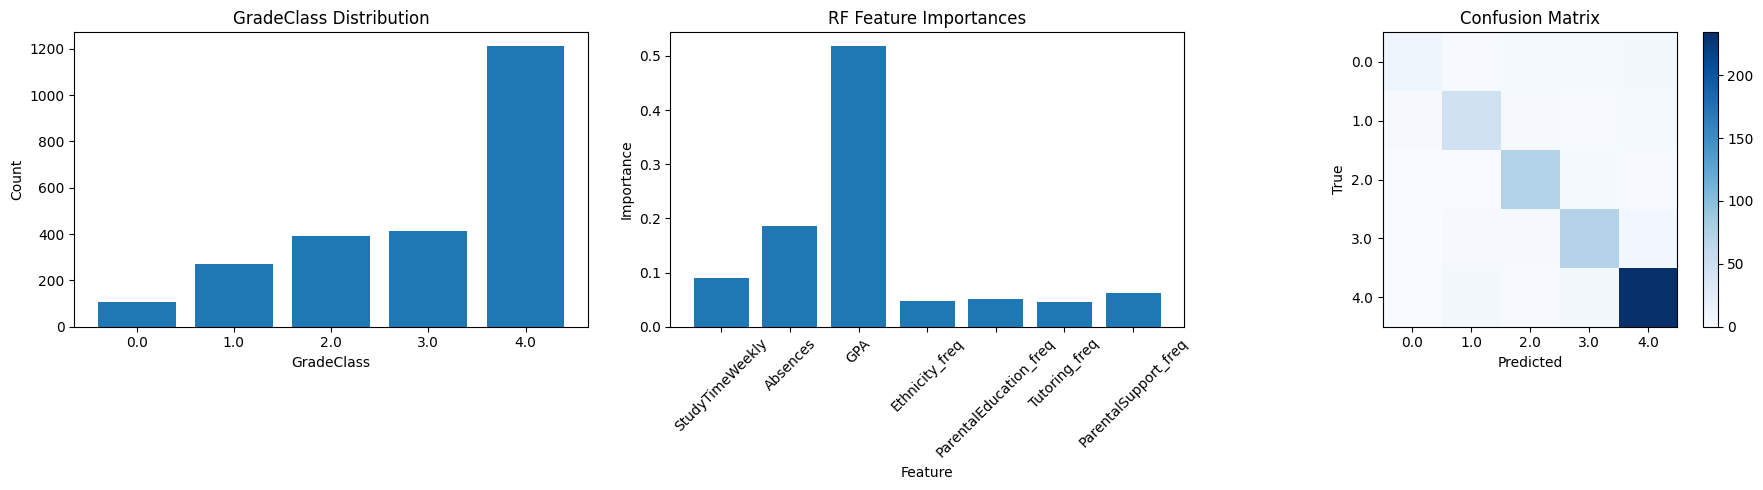

In [14]:
# --------- PLOTTING (combined) ---------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# A) GradeClass distribution
cls_vals, cls_counts = np.unique(y, return_counts=True)
axes[0].bar(cls_vals.astype(str), cls_counts)
axes[0].set_title('GradeClass Distribution')
axes[0].set_xlabel('GradeClass')
axes[0].set_ylabel('Count')

# B) Random Forest feature importances from the fitted ensemble
importances = voting.named_estimators_['rf'].feature_importances_
axes[1].bar(selected, importances)
axes[1].set_title('RF Feature Importances')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Feature')
axes[1].set_ylabel('Importance')

# C) Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred, labels=classes)
im = axes[2].imshow(cm, interpolation='nearest', cmap='Blues')
axes[2].set_title('Confusion Matrix')
axes[2].set_xticks(range(len(classes)))
axes[2].set_yticks(range(len(classes)))
axes[2].set_xticklabels(classes)
axes[2].set_yticklabels(classes)
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
fig.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

Plotting: Absences vs GPA | Correlation: -0.92


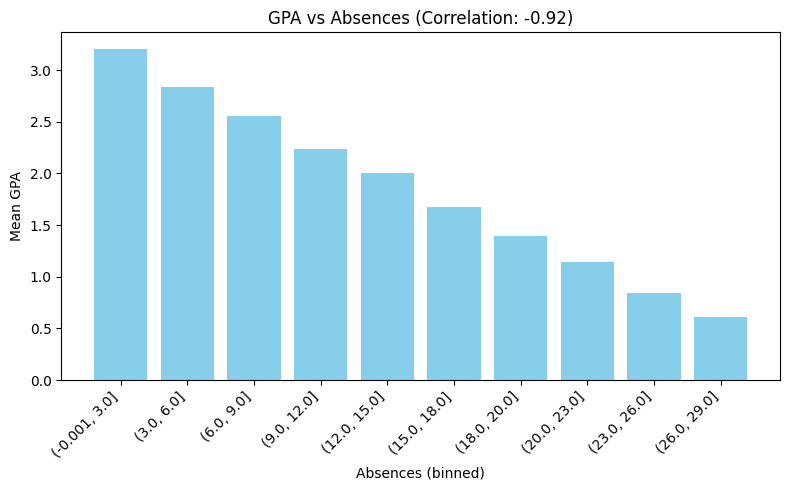

In [15]:
# -------- CORRELATION MATRIX AND HIGH-CORR PAIRS --------
X_selected_df = X[selected].copy()
corr_matrix = X_selected_df.corr()

high_corr_pairs = []
features = corr_matrix.columns
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((features[i], features[j], corr_val))

for f1, f2, corr in high_corr_pairs:
    print(f"Plotting: {f1} vs {f2} | Correlation: {corr:.2f}")
    plot_df = X_selected_df.copy()
    if np.issubdtype(plot_df[f1].dtype, np.number):
        plot_df["f1_bin"] = pd.qcut(plot_df[f1], q=10, duplicates='drop')
        grouped = plot_df.groupby("f1_bin", observed=False)[f2].mean()
        x_labels = grouped.index.astype(str)
        y_vals = grouped.values
        xlabel = f"{f1} (binned)"
    else:
        grouped = plot_df.groupby(f1)[f2].mean()
        x_labels = grouped.index
        y_vals = grouped.values
        xlabel = f1

    plt.figure(figsize=(8, 5))
    plt.bar(x_labels, y_vals, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{f2} vs {f1} (Correlation: {corr:.2f})")
    plt.xlabel(xlabel)
    plt.ylabel(f"Mean {f2}")
    plt.tight_layout()
    plt.show()

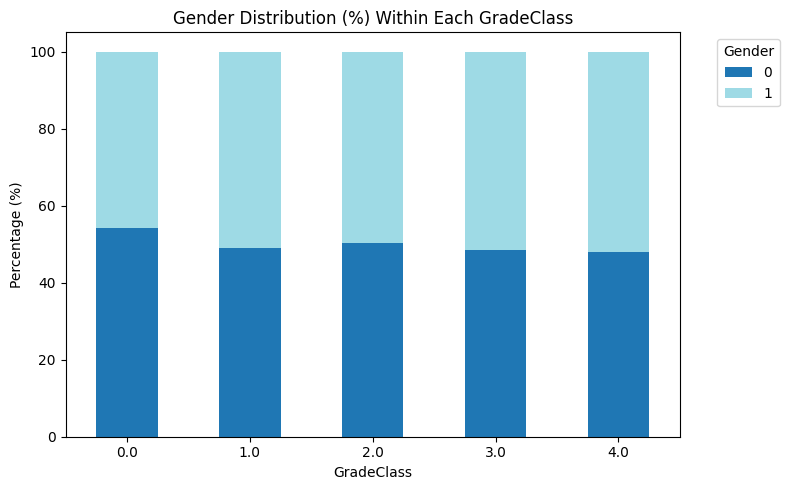

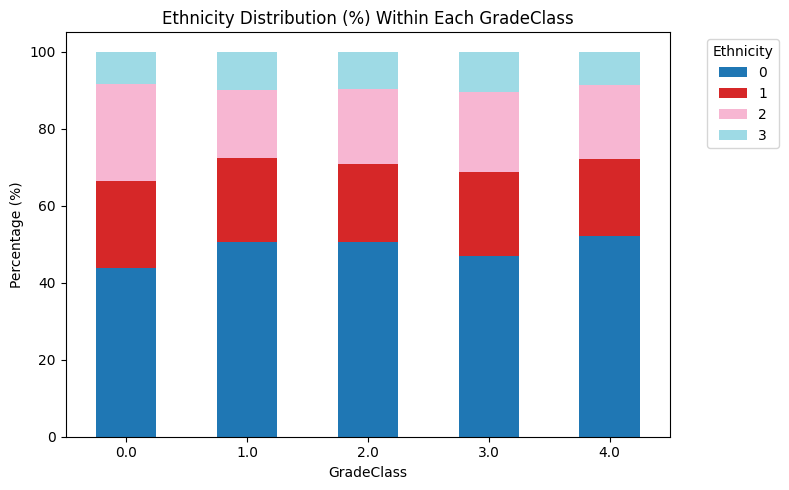

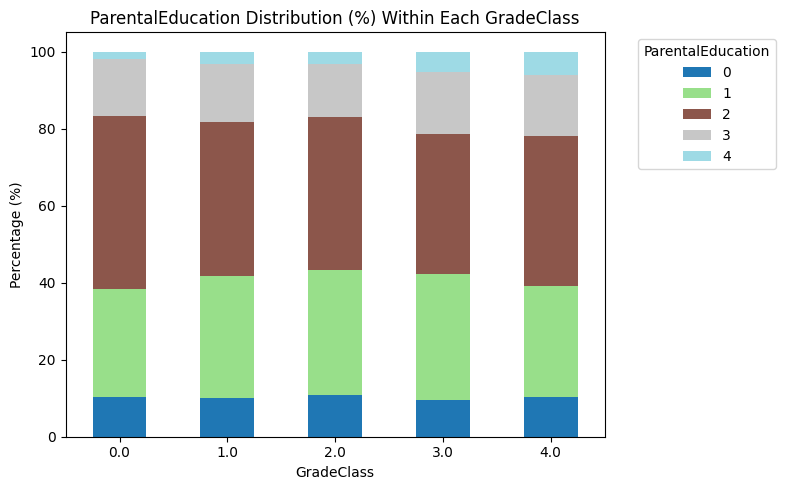

In [17]:
# -------- PERCENTAGE BAR CHARTS (categorical vs GradeClass) --------
df_original = pd.read_csv("Student_performance_data _.csv")  # reload unencoded data

plot_features = ["Gender", "Ethnicity", "ParentalEducation"]
for feature in plot_features:
    counts = df_original.groupby(["GradeClass", feature]).size().unstack(fill_value=0)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100

    percentages.plot(kind="bar", stacked=True, figsize=(8, 5), colormap="tab20")
    plt.title(f"{feature} Distribution (%) Within Each GradeClass")
    plt.xlabel("GradeClass")
    plt.ylabel("Percentage (%)")
    plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

ExactExplainer explainer: 480it [01:29,  5.28it/s]                         


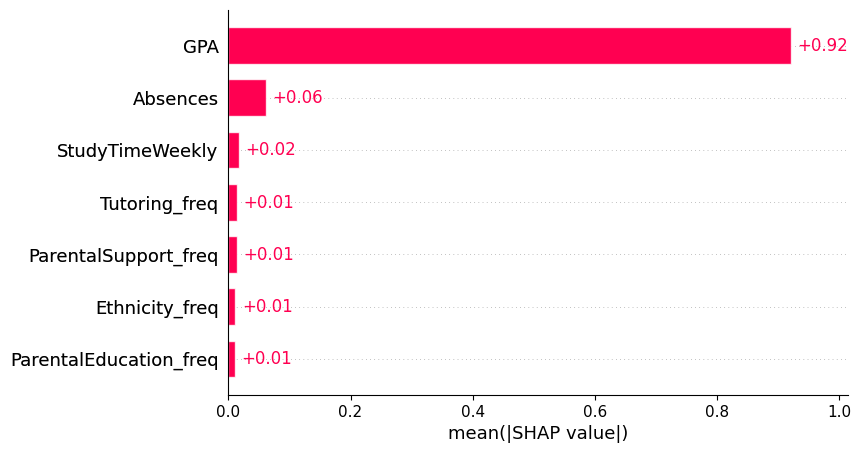

In [18]:
explainer_rf = shap.Explainer(rf.predict, X_test_sel)
shap_values_rf = explainer_rf(X_test_sel)

shap.plots.bar(shap_values_rf)